### Setup for Google Colab

If you are running this notebook in Google Colab, complete the following steps:

1. In Colab, we recommend going to **Runtime → Change runtime type** and selecting **T4 GPU**
2. Install **TerraTorch** and the required packages
3. Download the dataset (as part of the notebook)

In [ ]:
!pip install terratorch==1.2
!pip install gdown tensorboard

------------

## Notebook: Multitemporal Task with Prithvi

This demo notebook shows how to use the Prithvi model family, trained on temporal data, to build a TerraTorch downstream task that classifies crop type based on HLS time-series input data.


In [1]:
import os
import sys
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download a random subset for demos (~1 GB)
if not os.path.isfile('multi-temporal-crop-classification-subset.tar.gz'):
    gdown.download("https://drive.google.com/uc?id=1SycflNslu47yfMg2i_z8FqYkhZQv7JQM")

if not os.path.isdir('multi-temporal-crop-classification-subset/'):
    !tar -xzvf multi-temporal-crop-classification-subset.tar.gz

dataset_path = "multi-temporal-crop-classification-subset"

### Multi-temporal Crop Dataset

Lets start with analyzing the dataset


In [ ]:
!ls "{dataset_path}"

In [ ]:
# Each merged sample includes the stacked bands of three time steps
!ls "{dataset_path}/training_chips" | head

In [5]:
# Adjusted dataset class for this dataset (general dataset could be used as well)
datamodule = MultiTemporalCropClassificationDataModule(
    batch_size=8,
    num_workers=2,
    data_root=dataset_path,
    train_transform=[
        terratorch.datasets.transforms.FlattenTemporalIntoChannels(),  # Required for temporal data
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
        terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=3),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
    expand_temporal_dimension=True,
    use_metadata=False, # The crop dataset has metadata for location and time
    reduce_zero_label=True,
)

# Setup train and val datasets
datamodule.setup("fit")

In [ ]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds

In [ ]:
# checking datasets train split size
train_dataset = datamodule.train_dataset
len(train_dataset)

In [ ]:
# checking datasets available bands
train_dataset.all_band_names

In [ ]:
# checking datasets classes
train_dataset.class_names

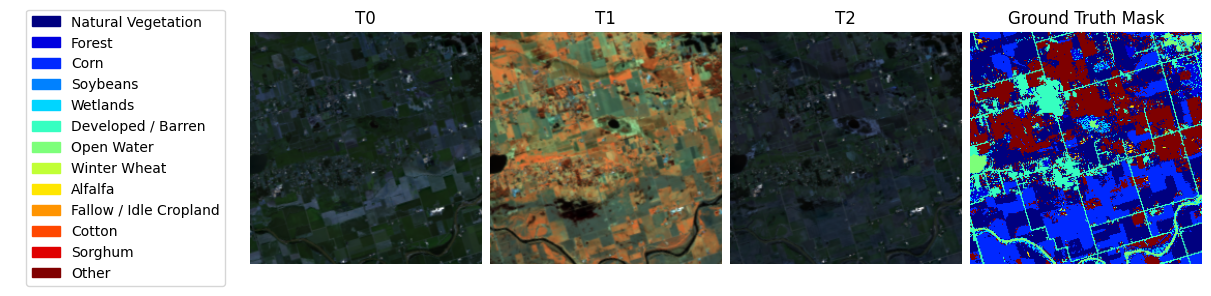

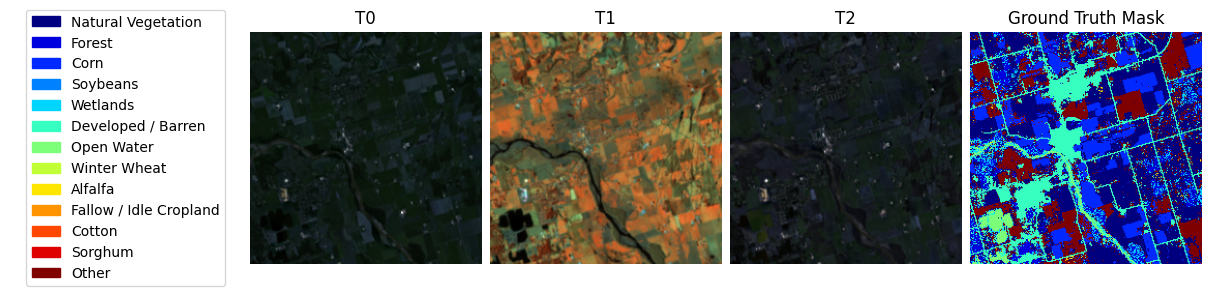

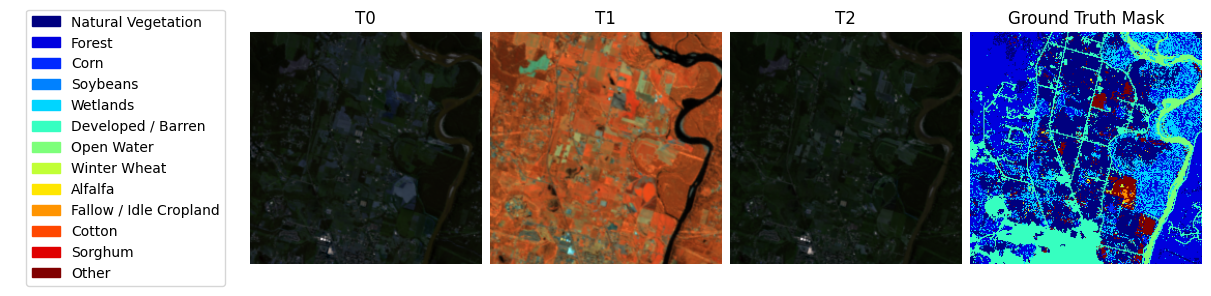

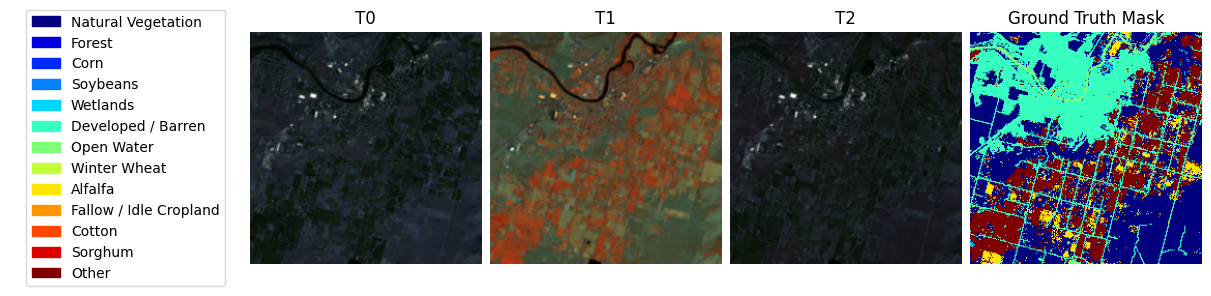

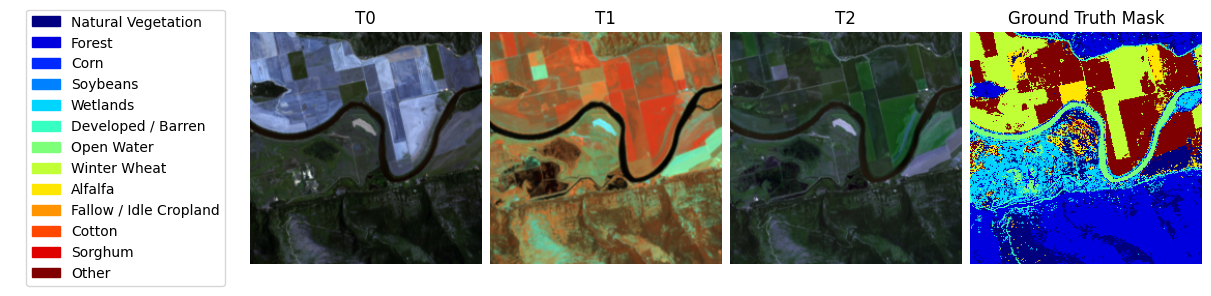

In [10]:
# plotting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [11]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

250

In [12]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

250

# Fine-tune Prithvi

In [ ]:
from terratorch.tasks import SemanticSegmentationTask

pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/multicrop/checkpoints/",
    mode="max",
    monitor="val/mIoU", # Variable to monitor
    filename="best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Lightning multi-gpu often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True, # Uses TensorBoard by default
    max_epochs=1, # For demos
    log_every_n_steps=5,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/multicrop",
)

# Model
model = SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": "prithvi_eo_v2_300_tl", # Model can be either prithvi_eo_v1_100, prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_pretrained": True,
        "backbone_num_frames": 3,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        "backbone_coords_encoding": [], # use ["time", "location"] for time and location metadata
        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11] # indices for prithvi_eo_v1_100
                "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
                # "indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
            },
            {
                "name": "ReshapeTokensToImage",
                "effective_time_dim": 3
            },
            {"name": "LearnedInterpolateToPyramidal"},            
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        
        # Head
        "head_dropout": 0.1,
        "num_classes": 13,
    },
    
    loss="ce",
    lr=1e-4,
    optimizer="AdamW",
    ignore_index=-1,
    freeze_backbone=True,  # Speeds up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    
)

In [ ]:
# Training
trainer.fit(model, datamodule=datamodule)

In [15]:
best_ckpt_path = "output/multicrop/checkpoints/best-epoch=00.ckpt"

In [16]:
def run_test_and_plot(model, ckpt_path):

    # calculate test metrics
    trainer.test(model, datamodule=datamodule, ckpt_path=ckpt_path)

    # get predictions
    preds = trainer.predict(model, datamodule=datamodule, ckpt_path=ckpt_path)

    # get data 
    data_loader = trainer.predict_dataloaders
    batch = next(iter(data_loader))

    # plot
    BATCH_SIZE = 8
    for i in range(BATCH_SIZE):

        sample = {key: batch[key][i] for key in batch}
        sample["prediction"] = preds[0][0][0][i].cpu().numpy()

        datamodule.predict_dataset.plot(sample)
        

In [ ]:
run_test_and_plot(model, best_ckpt_path)

## Training via CLI

Above, we introduced the required TerraTorch components and how to combine them flexibly. The same workflow can be run in a no-code setup by configuring all components in a YAML file and executing it via the PyTorch Lightning CLI.

We provide a sample YAML that reproduces the workflow above and serves as a starting point for similar pipelines.

**Note:** You may want to restart the session to free up memory before running the CLI workflow.

In [ ]:
# Run fine-tuning
!terratorch fit -c multitemporal_model_segementation_crop.yaml